### Main Adjustments
* For routes with no ride, replace non-count quantities by average
* 
* 

### load packages

In [19]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# ! pip install pyarrow fastparquet tqdm seaborn

### load data for range of time of choice
Two years and three months of data.

In [3]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,3+1,1)
years = np.arange(2023,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

In [4]:
month_year

array([[2023,    1],
       [2023,    2],
       [2023,    3]])

### Filter Manhattan Only and Remove Islands as in 01_e_adjacency_graph.ipynb

In [5]:
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [6]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True, taxi_zones=taxi_zones)
ts.head()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:22<00:00,  7.34s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,2023-01-01 00:00:00-05:00,4,4,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01 00:00:00-05:00,12,4,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01 00:00:00-05:00,13,4,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01 00:00:00-05:00,24,4,0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01 00:00:00-05:00,41,4,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
ts.pickup_datetime.min(), ts.pickup_datetime.max()

(Timestamp('2023-01-01 00:00:00-0500', tz='America/New_York'),
 Timestamp('2023-03-31 23:00:00-0400', tz='America/New_York'))

In [8]:
# basic checks, notice our code accounts for Daylight Savings Time
print('Min Date: ', ts.pickup_datetime.min())
print('Max Date: ', ts.pickup_datetime.max())
print('Taxi Zones: ' + str(ts.PULocationID.unique().min()) + ' to ' + str(ts.PULocationID.unique().max()) )
print('Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Min Date:  2023-01-01 00:00:00-05:00
Max Date:  2023-03-31 23:00:00-04:00
Taxi Zones: 4 to 263
Memory Usage (MB):  336.8226318359375


In [9]:
ts.dtypes

pickup_datetime    datetime64[us, America/New_York]
DOLocationID                                  int32
PULocationID                                  int32
counts                                        int32
total_amount                                float32
tip_amount                                  float32
fare_amount                                 float32
trip_distance                               float32
passenger_count                             float32
trip_duration                               float32
dtype: object

In [10]:
import datetime as dt
fare_hike_date = pd.Timestamp('2022-12-19 00:00:00').tz_localize('America/New_York', ambiguous = True) # need to specify time zone to avoid ambiguity

### correct for fare hike and save dataframe

In [11]:
ts_adj = ts.copy()
prices = ['fare_amount', 'total_amount', 'tip_amount']
# 23% fare hike: this simpler implementation better than only modifying fare price and recalculating total amount
for price in prices:
    ts_adj[price] = np.where(ts['pickup_datetime'] <= fare_hike_date, ts[price] * 1.23, ts[price]) 

In [12]:
ts_route = ts_adj[(ts_adj['DOLocationID'] == 42) & (ts_adj['PULocationID'] == 79)]
ts_route

,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
788,2023-01-01 00:00:00-05:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000
4499,2023-01-01 01:00:00-05:00,42,79,1,46.560001,7.76,33.799999,7.610,1.0,25.316668
8210,2023-01-01 02:00:00-05:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000
11921,2023-01-01 03:00:00-05:00,42,79,2,44.459999,7.41,32.049999,7.125,1.0,25.674999
15632,2023-01-01 04:00:00-05:00,42,79,2,41.980003,3.88,33.099998,8.175,1.0,16.783333
...,...,...,...,...,...,...,...,...,...,...
8009051,2023-03-31 19:00:00-04:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000
8012782,2023-03-31 20:00:00-04:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000
8016513,2023-03-31 21:00:00-04:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000
8020244,2023-03-31 22:00:00-04:00,42,79,0,0.000000,0.00,0.000000,0.000,0.0,0.000000


In [13]:
ts_route['total_amount'][ts_route['total_amount'] == 0] = ts_route[ts_route['total_amount'] != 0]['total_amount'].mean()
ts_route['tip_amount'][ts_route['tip_amount'] == 0] = ts_route[ts_route['tip_amount'] != 0]['tip_amount'].mean()
ts_route['fare_amount'][ts_route['fare_amount'] == 0] = ts_route[ts_route['fare_amount'] != 0]['fare_amount'].mean()
ts_route['trip_distance'][ts_route['trip_distance'] == 0] = ts_route[ts_route['trip_distance'] != 0]['trip_distance'].mean()
ts_route['passenger_count'][ts_route['passenger_count'] == 0] = ts_route[ts_route['passenger_count'] != 0]['passenger_count'].mean()
ts_route['trip_duration'][ts_route['trip_duration'] == 0] = ts_route[ts_route['trip_duration'] != 0]['trip_duration'].mean()

/tmp/ipykernel_15404/3010030529.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ts_route['total_amount'][ts_route['total_amount'] == 0] = ts_route[ts_route['total_amount'] != 0]['total_amount'].mean()
/tmp/ipykernel_15404/3010030529.py:1

In [14]:
cols = ['total_amount', 'fare_amount', 'tip_amount', 'trip_distance', 'passenger_count', 'trip_duration']

In [15]:
# replace zero amount non-counts quantities with time average of quantities in specific DOLocationID and PULocationID
ts_test = ts_adj.copy()
for c in cols:
    # Calculate average price per (latitude, longitude) where average_price is not zero
    avg_c_by_route = ts_test[ts_test[c] != 0].groupby(['DOLocationID', 'PULocationID'])[c].mean().reset_index()
    avg_c_by_route.rename(columns={c : 'avg_c_route'}, inplace=True)

    # Merge this average price back to the original dataframe
    ts_test = ts_test.merge(avg_c_by_route, on=['DOLocationID', 'PULocationID'], how='left')

    # Replace zero average prices with the calculated average price per location
    ts_test.loc[ts_test[c] == 0, c] = ts_test['avg_c_route']

    # Drop the temporary column
    ts_test.drop(columns=['avg_c_route'], inplace=True)

In [17]:
ts_test_route = ts_test[(ts_test['DOLocationID'] == 42) & (ts_test['PULocationID'] == 79)]
ts_test_route

,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
788,2023-01-01 00:00:00-05:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996
4499,2023-01-01 01:00:00-05:00,42,79,1,46.560001,7.760000,33.799999,7.610000,1.000000,25.316668
8210,2023-01-01 02:00:00-05:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996
11921,2023-01-01 03:00:00-05:00,42,79,2,44.459999,7.410000,32.049999,7.125000,1.000000,25.674999
15632,2023-01-01 04:00:00-05:00,42,79,2,41.980003,3.880000,33.099998,8.175000,1.000000,16.783333
...,...,...,...,...,...,...,...,...,...,...
8009051,2023-03-31 19:00:00-04:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996
8012782,2023-03-31 20:00:00-04:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996
8016513,2023-03-31 21:00:00-04:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996
8020244,2023-03-31 22:00:00-04:00,42,79,0,46.350594,6.787961,35.915459,8.106826,1.403175,25.443996


In [67]:
ts_test

,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,2023-01-01 00:00:00-05:00,4,4,0,16.314268,2.831606,9.891079,0.751954,1.261391,4.670224
1,2023-01-01 00:00:00-05:00,12,4,0,23.120001,3.186667,15.599999,3.316667,3.000000,8.505555
2,2023-01-01 00:00:00-05:00,13,4,0,28.832291,4.831250,20.222918,3.977917,1.479167,14.396874
3,2023-01-01 00:00:00-05:00,24,4,0,43.145000,6.527500,32.549999,7.215714,1.357143,23.829762
4,2023-01-01 00:00:00-05:00,41,4,0,44.648205,7.312667,34.369232,7.409102,1.307692,29.645514
...,...,...,...,...,...,...,...,...,...,...
8026904,2023-03-31 23:00:00-04:00,246,263,0,34.559216,5.022802,25.499418,4.642251,1.366795,23.848316
8026905,2023-03-31 23:00:00-04:00,249,263,2,46.320000,8.570000,32.750000,5.940000,1.500000,30.741665
8026906,2023-03-31 23:00:00-04:00,261,263,0,43.874653,6.372280,34.436062,8.066958,1.285311,20.893644
8026907,2023-03-31 23:00:00-04:00,262,263,1,13.100000,3.000000,5.100000,0.500000,1.000000,3.583333


In [68]:
ts_adj = ts_test.copy()
ts_adj_79 = ts_adj[ts_adj['PULocationID'] == 79]
gb = ts_adj_79.groupby(['pickup_datetime', 'PULocationID'])

In [69]:
# weighted-average function accounting for zero-weights
def weighted_average(x, weights):
    if weights.sum() == 0.:
        return 0.
    return np.average(x, weights=weights)

# from groupby, sum the counts and perform weighted average of total_amount, etc. using counts as weights
ts_adj_79_p = pd.DataFrame(gb['counts'].sum())
ts_adj_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
ts_adj_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
ts_adj_79_p['tip_amount'] = gb.apply(lambda x: weighted_average(x['tip_amount'], weights=x['counts']))
ts_adj_79_p['trip_distance'] = gb.apply(lambda x: weighted_average(x['trip_distance'], weights=x['counts']))
ts_adj_79_p['passenger_count'] = gb.apply(lambda x: weighted_average(x['passenger_count'], weights=x['counts']))
ts_adj_79_p['trip_duration'] = gb.apply(lambda x: weighted_average(x['trip_duration'], weights=x['counts']))
ts_adj_79_p = ts_adj_79_p.reset_index()

/tmp/ipykernel_10433/1387615273.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_adj_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
/tmp/ipykernel_10433/1387615273.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_adj_79_p['fare_amount'] = gb.apply(lambda x: weighted_average(x['fare_amount'], weights=x['counts']))
/tmp/ipykernel_10433/13876152

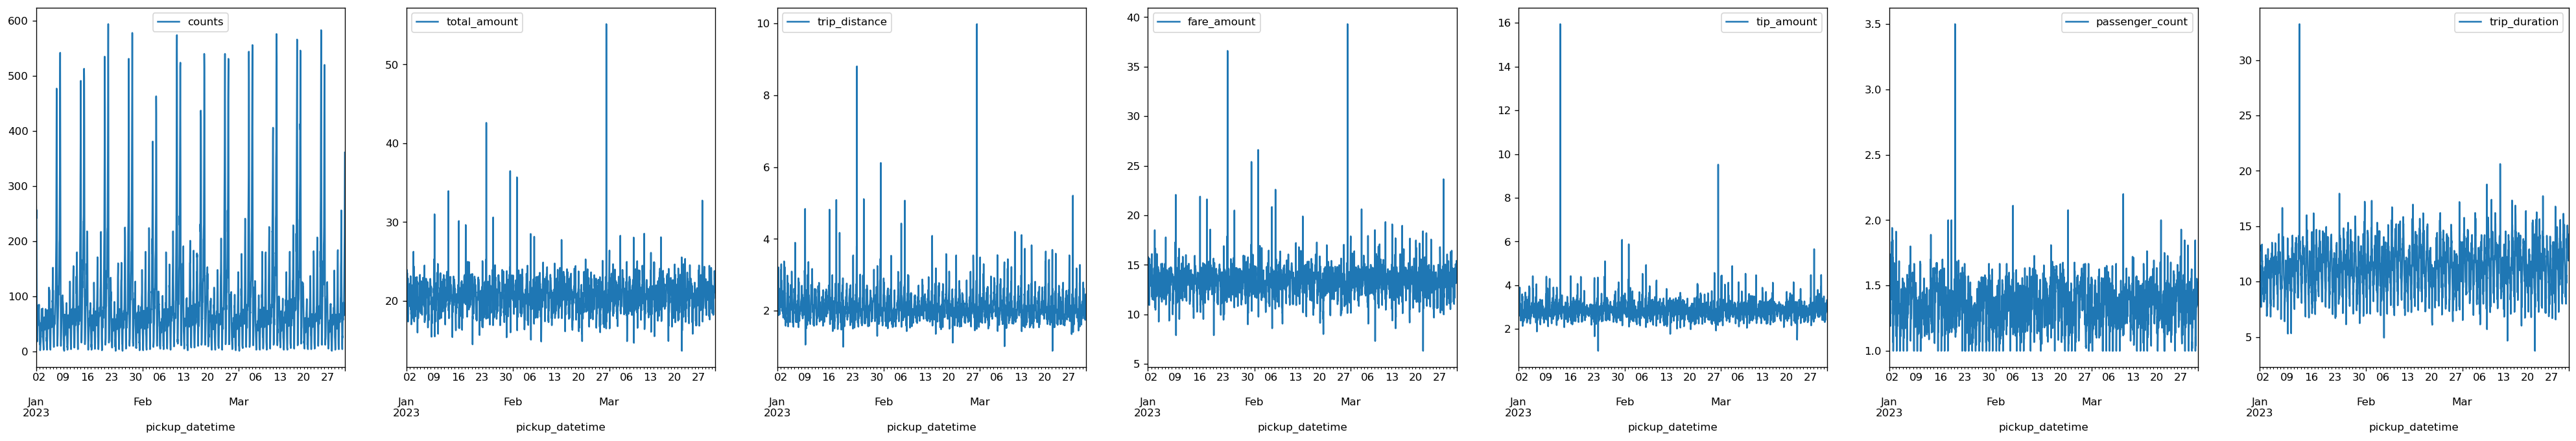

In [70]:
fig, axes = plt.subplots(figsize = (6*7, 6), dpi = 120, nrows = 1, ncols = 7)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'passenger_count', 'trip_duration']):
    ts_adj_79_p.plot(x = 'pickup_datetime', y = col, ax = axes[i])

In [71]:
ts_adj['trip_duration']

0           4.670224
1           8.505555
2          14.396874
3          23.829762
4          29.645514
             ...    
8026904    23.848316
8026905    30.741665
8026906    20.893644
8026907     3.583333
8026908     2.166667
Name: trip_duration, Length: 8026909, dtype: float32

In [ ]:
# save time series as pd dataframe outside github repo
os.system('mkdir -p ../../processed_taxi_data')
ts.to_pickle('../../processed_taxi_data/adjusted_yellow_2022-01_2024-03.pkl')

In [ ]:
# load raw data without processing